### This notebook takes 6 day of normalized (percentile 33, 66) MS data and create a bayesian network 

In [4]:
import pickle
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import pylab as plt
from pgmpy.inference import VariableElimination
import pdb
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

ModuleNotFoundError: No module named 'pgmpy'

In [4]:
## Load Sequences (Normalized using percentiles) (six days)

data_features = pd.read_csv('csv_files_MS/final_MS_df_variables.csv')
for i in range(len(data_features)):
    data_features.loc[i, 'Patient_ID'] = str(data_features.loc[i, 'Patient_ID'])
#Load the processed and normalized  dataset 
with open('MS_normalized_df_six_days.pkl', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    data.loc[i, 'Patient_ID'] = str(data.loc[i, 'Patient_ID'])

#Load the processed and normalized  dataset 
with open('MS_normalized_df.pkl', 'rb') as f:
    data_full = pickle.load(f)

for i in range(len(data)):
    data_full.loc[i, 'Patient_ID'] = str(data_full.loc[i, 'Patient_ID'])


In [5]:
data[data["Patient_ID"] == "1033"].tail(1)["EOD_PAW"]

929    Higher
Name: EOD_PAW, dtype: object

In [6]:
data_full[data_full["Patient_ID"] == "1005"]

,Patient_ID,Gender,Age,Daytime_Interval,Patient_Interval_Number,Pain_Score,Action_Pain,Fatigue_Score,Action_Fatigue,Last_Activitybout_State,Current_Activitybout_Action,EOD_PAW,Action_PAW
140,1005,Female,Between 30 to 60,Wake,1,Higher,Recorded,Normal,Recorded,Not Recorded,Normal,None,None
141,1005,Female,Between 30 to 60,Morning,2,Higher,Recorded,Lower,Recorded,Normal,Higher,None,None
142,1005,Female,Between 30 to 60,Afternoon,3,Higher,Recorded,Normal,Recorded,Higher,Lower,None,None
143,1005,Female,Between 30 to 60,Evening,4,Higher,Recorded,Normal,Recorded,Lower,Lower,None,Recorded
144,1005,Female,Between 30 to 60,Bed,5,Higher,Recorded,Normal,Recorded,Lower,Higher,Normal,None
145,1005,Female,Between 30 to 60,Wake,6,Normal,Recorded,Lower,Recorded,Higher,Higher,None,None
146,1005,Female,Between 30 to 60,Morning,7,Normal,Recorded,Lower,Recorded,Higher,Normal,None,None
147,1005,Female,Between 30 to 60,Afternoon,8,Lower,Recorded,Lower,Recorded,Normal,Lower,None,None
148,1005,Female,Between 30 to 60,Evening,9,Normal,Recorded,Lower,Recorded,Lower,Lower,None,Recorded
149,1005,Female,Between 30 to 60,Bed,10,Normal,Recorded,Normal,Recorded,Lower,Normal,Normal,None


In [7]:
data_features_new = data_features.drop(data_features[(data_features['Patient_Interval_Number'] <30) | (data_features['Patient_Interval_Number'] == 35)].index).reset_index(drop=True)
data_features_dummy = data_features.drop(data_features[(data_features['Patient_Interval_Number'] <31)].index).reset_index(drop=True)
data_features_new["Next_Pain"] = data_features_dummy["Pain_Score"]
data_features_new["Next_Fatigue"] = data_features_dummy["Fatigue_Score"]
data_features_new["Next_PAW"] = data_features_dummy["EOD_PAW"]
data_features_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_features_true = data_features_new.copy()
data_features_true.fillna(value="None", inplace = True)
data_features_new.drop(columns = ["Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)
############### Replace. None-> "None" ####
data_features_new.fillna(value="None", inplace = True)

In [8]:
data_features_new

,Gender,Age,Start_Day_Anna,Education,Living_Alone,Work,Use_Mobility_Aids,MS_Subtype,How_long,Start_Date,...,Action_fatigue,Action_Cognition,Action_Depression,Record_Next_PAW,Action_SRA,Action_UE,Action_LE,Next_Pain,Next_Fatigue,Next_PAW
0,Female,50 and Older,Mon,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-13,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
1,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
2,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,Low,Not Recorded
3,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,Low,Not Recorded
4,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Recorded,Recorded,Recorded,Recorded,Low,Low,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Female,Between 20 to 50,Wed,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-06,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
531,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,High,Not Recorded
532,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Moderate,Moderate,Not Recorded
533,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded


In [9]:
# data_full_new = data_full[data_full['Patient_Interval_Number'] >31 and data_full['Patient_Interval_Number'] <35] 
data_full_new = data_full.drop(data_full[(data_full['Patient_Interval_Number'] <30) | (data_full['Patient_Interval_Number'] == 35)].index).reset_index(drop=True)
data_full_dummy = data_full.drop(data_full[(data_full['Patient_Interval_Number'] <31)].index).reset_index(drop=True)
data_full_new["Next_Pain"] = data_full_dummy["Pain_Score"]
data_full_new["Next_Fatigue"] = data_full_dummy["Fatigue_Score"]
data_full_new["Next_PAW"] = data_full_dummy["EOD_PAW"]
data_full_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_full_true = data_full_new.copy()
data_full_true.fillna(value="None", inplace = True)
data_full_new.drop(columns = ["Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)
############### Replace. None-> "None" ####
data_full_new.fillna(value="None", inplace = True)






In [10]:
data_full_new

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_Pain,Next_Fatigue,Next_PAW
0,Female,Between 30 to 60,Bed,Normal,Not Recorded,Higher,Not Recorded,Normal,Lower,None,Not Recorded,Not Recorded,None
1,Female,Between 30 to 60,Wake,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Lower,Lower,None,Not Recorded,Not Recorded,None
2,Female,Between 30 to 60,Morning,Not Recorded,Recorded,Not Recorded,Recorded,Lower,Lower,None,Higher,Normal,None
3,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Lower,None,Normal,Normal,None
4,Female,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Female,Between 30 to 60,Bed,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Higher,Higher,None,Not Recorded,Not Recorded,None
531,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None,Lower,Higher,None
532,Female,Between 30 to 60,Morning,Lower,Recorded,Higher,Recorded,Lower,Lower,None,Normal,Normal,None
533,Female,Between 30 to 60,Afternoon,Normal,Not Recorded,Normal,Not Recorded,Lower,Higher,None,Not Recorded,Not Recorded,None


In [11]:
print(data.shape)

(3210, 13)


In [12]:
data_new = pd.DataFrame()

In [13]:
data_new = data.drop(data[data['Patient_Interval_Number'] == 30].index).reset_index()
data_dummy = data.drop(data[data['Patient_Interval_Number'] == 1].index).reset_index()
    

In [14]:
data_new["Next_Pain"] = data_dummy["Pain_Score"]
data_new["Next_Fatigue"] = data_dummy["Fatigue_Score"]
data_new["Next_PAW"] = data_dummy["EOD_PAW"]
#data_new.drop(columns[""])

In [15]:
data_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_new.drop(columns = ["index", "Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)


In [16]:
data_new

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_Pain,Next_Fatigue,Next_PAW
0,Female,Between 30 to 60,Wake,Higher,Recorded,Normal,Recorded,Not Recorded,Higher,None,Lower,Lower,None
1,Female,Between 30 to 60,Morning,Lower,Recorded,Lower,Recorded,Higher,Normal,None,Higher,Normal,None
2,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Normal,Higher,None,Higher,Higher,None
3,Female,Between 30 to 60,Evening,Higher,Recorded,Higher,Recorded,Higher,Lower,Recorded,Normal,Higher,Normal
4,Female,Between 30 to 60,Bed,Normal,Recorded,Higher,Recorded,Lower,Lower,None,Normal,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,Female,Between 30 to 60,Bed,Lower,Not Recorded,Not Recorded,Not Recorded,Higher,Normal,None,Not Recorded,Not Recorded,None
3099,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Normal,Lower,None,Lower,Normal,None
3100,Female,Between 30 to 60,Morning,Lower,Recorded,Normal,Recorded,Lower,Lower,None,Higher,Normal,None
3101,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Normal,None,Normal,Lower,None


In [17]:
############### Replace. None-> "None" ####
data_new.fillna(value="None", inplace = True)
#data_new.fillna(value= pd.np.nan, inplace = True)

In [18]:
data_new.to_csv("csv_files_MS/Bayesian_MS_data_six_days.csv", index = False)

In [19]:
len(data_new.dtypes)

13

In [20]:
data_new.dtypes

Gender                      object
Age                         object
Current_Daytime_Interval    object
Current_Pain                object
Record_Next_Pain            object
Current_Fatigue             object
Record_Next_Fatigue         object
Last_Acbout                 object
Current_Acbout              object
Record_Next_PAW             object
Next_Pain                   object
Next_Fatigue                object
Next_PAW                    object
dtype: object

### Lets start Bayesian

In [2]:
#create list of tuples for 13 node connections
list_of_tup = [("Gender", "Current_Pain"), ("Gender", "Next_Pain"), ("Gender", "Next_PAW"), ("Gender", "Next_Fatigue"), ("Gender", "Current_Fatigue"),
              ("Age", "Current_Pain"), ("Age", "Next_Pain"), ("Age", "Next_PAW"), ("Age", "Next_Fatigue"), ("Age", "Current_Fatigue"),
              ("Current_Daytime_Interval", "Current_Pain"), ("Current_Daytime_Interval", "Next_Pain"), ("Current_Daytime_Interval", "Next_PAW"), ("Current_Daytime_Interval", "Next_Fatigue"), ("Current_Daytime_Interval", "Current_Fatigue"),
              ("Last_Acbout", "Current_Fatigue"), 
              ("Current_Pain", "Next_Pain"), ("Current_Pain", "Current_Fatigue"),
              ("Current_Fatigue", "Next_Fatigue"),
              ("Current_Acbout", "Next_PAW"), ("Current_Acbout", "Next_Fatigue"), 
              ("Record_Next_Pain", "Next_Pain"), 
              ("Record_Next_Fatigue", "Next_Fatigue"), 
              ("Record_Next_PAW", "Next_PAW"), 
              ("Next_Pain", "Next_PAW"), ("Next_Pain", "Next_Fatigue"), 
              ("Next_Fatigue", "Next_PAW")]


# list_of_tup = [("Gender", "Current_Pain"), ("Gender", "Next_Pain"), ("Gender", "Next_PAW"), ("Gender", "Next_Fatigue"), ("Gender", "Current_Fatigue"),
#               ("Age", "Current_Pain"), ("Age", "Next_Pain"), ("Age", "Next_PAW"), ("Age", "Next_Fatigue"), ("Age", "Current_Fatigue"),
#               ("Current_Daytime_Interval", "Current_Pain"), ("Current_Daytime_Interval", "Next_Pain"), ("Current_Daytime_Interval", "Next_PAW"), ("Current_Daytime_Interval", "Next_Fatigue"), ("Current_Daytime_Interval", "Current_Fatigue"),
#               ("Last_Acbout", "Current_Fatigue"), 
#               ("Current_Pain", "Next_Pain"), ("Current_Pain", "Current_Fatigue"),
#               ("Current_Fatigue", "Next_Fatigue"),
#               ("Current_Acbout", "Next_PAW"), ("Current_Acbout", "Next_Fatigue"), 
#               ("Record_Next_Pain", "Next_Pain"), 
#               ("Record_Next_Fatigue", "Next_Fatigue"),
#               ("Next_Pain", "Next_PAW"), ("Next_Pain", "Next_Fatigue"), 
#               ("Next_Fatigue", "Next_PAW")]



In [3]:
model = BayesianModel(list_of_tup)

NameError: name 'BayesianModel' is not defined

<IPython.core.display.Javascript object>


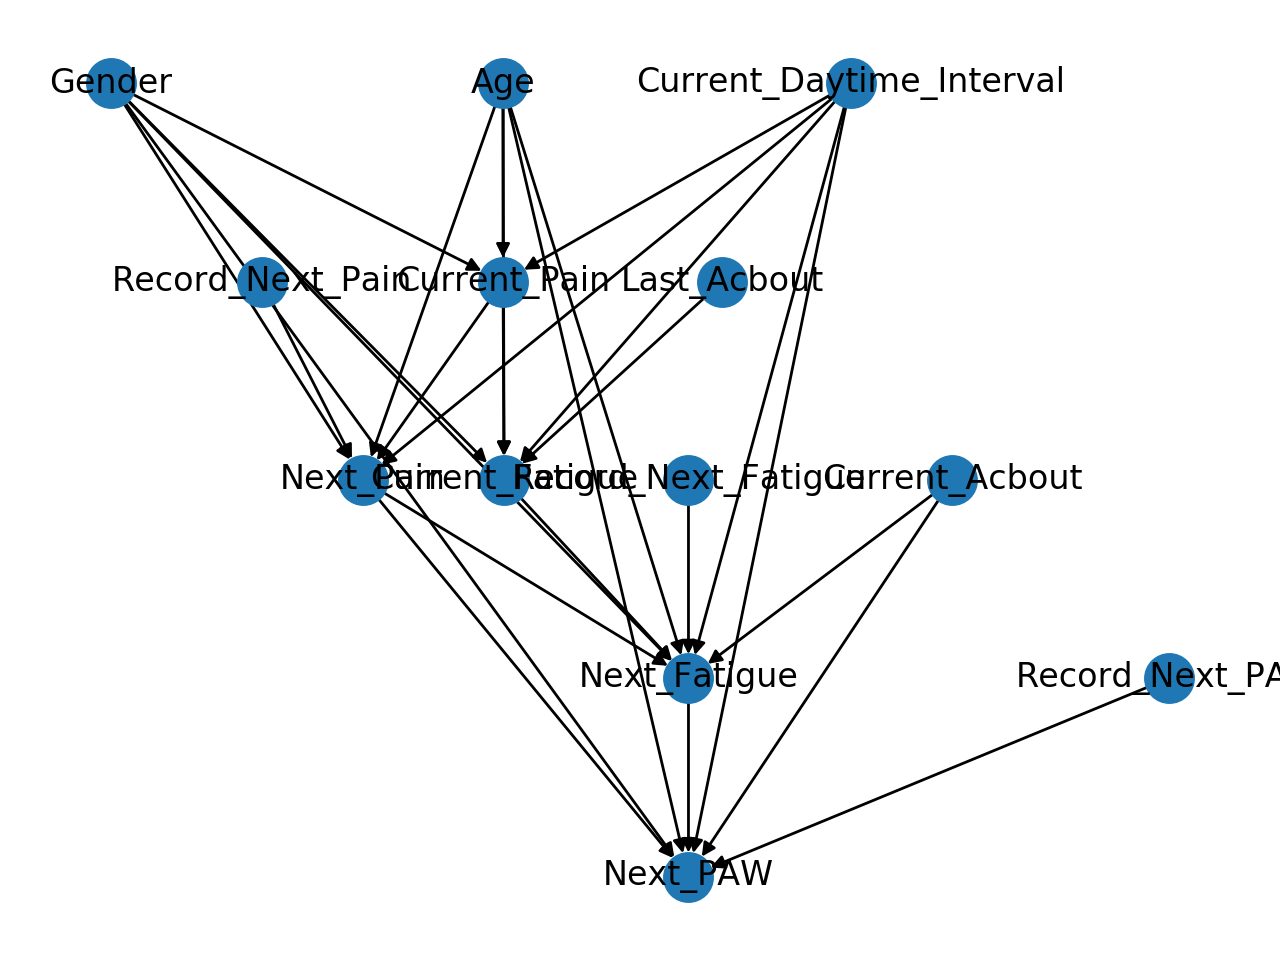

In [23]:
%matplotlib notebook
#Draw
# nx.draw(model, with_labels=True)
# plt.show()
pos = graphviz_layout(model, prog = 'dot')
nx.draw(model,with_labels=True, pos = pos)

In [24]:
#Fitting the model with data
# Learing CPDs using Maximum Likelihood Estimators
#model.fit(data_new[:3000], estimator=BayesianEstimator)
model.fit(data_new, estimator=BayesianEstimator)

In [25]:
model.nodes()

NodeView(('Gender', 'Current_Pain', 'Next_Pain', 'Next_PAW', 'Next_Fatigue', 'Current_Fatigue', 'Age', 'Current_Daytime_Interval', 'Last_Acbout', 'Current_Acbout', 'Record_Next_Pain', 'Record_Next_Fatigue', 'Record_Next_PAW'))

In [26]:
model.edges()

OutEdgeView([('Gender', 'Current_Pain'), ('Gender', 'Next_Pain'), ('Gender', 'Next_PAW'), ('Gender', 'Next_Fatigue'), ('Gender', 'Current_Fatigue'), ('Current_Pain', 'Next_Pain'), ('Current_Pain', 'Current_Fatigue'), ('Next_Pain', 'Next_PAW'), ('Next_Pain', 'Next_Fatigue'), ('Next_Fatigue', 'Next_PAW'), ('Current_Fatigue', 'Next_Fatigue'), ('Age', 'Current_Pain'), ('Age', 'Next_Pain'), ('Age', 'Next_PAW'), ('Age', 'Next_Fatigue'), ('Age', 'Current_Fatigue'), ('Current_Daytime_Interval', 'Current_Pain'), ('Current_Daytime_Interval', 'Next_Pain'), ('Current_Daytime_Interval', 'Next_PAW'), ('Current_Daytime_Interval', 'Next_Fatigue'), ('Current_Daytime_Interval', 'Current_Fatigue'), ('Last_Acbout', 'Current_Fatigue'), ('Current_Acbout', 'Next_PAW'), ('Current_Acbout', 'Next_Fatigue'), ('Record_Next_Pain', 'Next_Pain'), ('Record_Next_Fatigue', 'Next_Fatigue'), ('Record_Next_PAW', 'Next_PAW')])

In [529]:
#model.get_independencies()

In [530]:
#model.get_cpds()

In [28]:
# Printing a CPD with it's state names defined.
cpd_pain = model.get_cpds('Next_Pain')

In [33]:
#cpd_pain.evidence

AttributeError: 'TabularCPD' object has no attribute 'evidence'

In [532]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected (i.e. correlated) by any 
# change in the node passed in the argument.
#model.active_trail_nodes('Next_Pain')

In [533]:
#model.active_trail_nodes('Next_Pain', observed='Current_Pain')

In [614]:
### Inference
# from pgmpy.inference import VariableElimination
# infer = VariableElimination(model)
# next_pain_dist = infer.query(['Next_PAW'])
# print(next_pain_dist)

In [535]:
#print(infer.query(['Next_Pain'], evidence={'Current_Pain': 'Not Recorded', 'Current_Fatigue': 'Not Recorded'}))

Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here's an example:

In [536]:
#print(infer.map_query(['Next_Fatigue'], evidence = predict_data[:2].to_dict('index')[3001]))

In [537]:
#infer = VariableElimination(model)
# query = infer.query(['Next_Pain', "Next_Fatigue", "Next_PAW"], joint = True, evidence = predict_data[:2].to_dict('index')[3001])
# print(query)

### Validation (Using joint probability)

In [538]:
infer = VariableElimination(model)

In [ ]:
test = infer.query(['Next_Pain', "Next_Fatigue"], joint = True, evidence = evidence = {'Current_Daytime_Interval':"Bed", 'Record_Next_Fatigue': "Recorded"}, show_progress=False)

In [575]:
def joint_proba_table(current_query):
    col = current_query.variables
    joint_proba_df = pd.DataFrame(columns = col)
    index = 0
    predict_dict = {}
    #pdb.set_trace()
    if(len(col) == 3):
        for i in range(current_query.values.shape[0]):
            for j in range(current_query.values.shape[1]):
                for k in range(current_query.values.shape[2]):
                    joint_proba_df.loc[index, col[0]] = i
                    joint_proba_df.loc[index, col[1]] = j
                    joint_proba_df.loc[index, col[2]] = k
                    joint_proba_df.loc[index, "Phi"] = query.values[i, j, k]
                    index+=1
        joint_proba_df["Next_Pain"].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
        joint_proba_df["Next_Fatigue"].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
        joint_proba_df["Next_PAW"].replace({0: "Higher", 1: "Lower", 2:"None", 3:"Normal", 4:"Not Recorded"}, inplace=True)
        #max_joint_proba, max_joint_proba_index = joint_proba_df['Phi'].max(), joint_proba_df[['Phi']].idxmax()
        dic = joint_proba_df['Phi'].nlargest(2).to_dict()
        max1_index, max2_index = dic.keys()
        max1, max2 = dic.values()
        
        #pdb.set_trace()
        predict_dict = {"Pain": joint_proba_df.loc[max1_index, "Next_Pain"], 
                        "Fatigue": joint_proba_df.loc[max1_index, "Next_Fatigue"], 
                        "PAW": joint_proba_df.loc[max1_index, "Next_PAW"],
                        "Pain2": joint_proba_df.loc[max2_index, "Next_Pain"], 
                        "Fatigue2": joint_proba_df.loc[max2_index, "Next_Fatigue"], 
                        "PAW2": joint_proba_df.loc[max2_index, "Next_PAW"]
                       }
    elif(len(col) == 2):
        for i in range(current_query.values.shape[0]):
            for j in range(current_query.values.shape[1]):
                joint_proba_df.loc[index, col[0]] = i
                joint_proba_df.loc[index, col[1]] = j
                joint_proba_df.loc[index, "Phi"] = query.values[i, j]
                index+=1
        #max_joint_proba, max_joint_proba_index = joint_proba_df['Phi'].max(), joint_proba_df[['Phi']].idxmax()
        #pdb.set_trace()
        dic = joint_proba_df['Phi'].nlargest(2).to_dict()
        max1_index, max2_index = dic.keys()
        max1, max2 = dic.values()
        if("Next_Pain" in col):
            joint_proba_df[col[col.index("Next_Pain")]].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
            predict_dict["Pain"] = joint_proba_df.loc[max1_index, "Next_Pain"]
            predict_dict["Pain2"] = joint_proba_df.loc[max2_index, "Next_Pain"]
        if("Next_Fatigue" in col):
            joint_proba_df[col[col.index("Next_Fatigue")]].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
            predict_dict["Fatigue"] = joint_proba_df.loc[max1_index, "Next_Fatigue"]
            predict_dict["Fatigue2"] = joint_proba_df.loc[max2_index, "Next_Fatigue"]
        if("Next_PAW" in col):
            joint_proba_df[col[col.index("Next_PAW")]].replace({0: "Higher", 1: "Lower", 2:"None", 3:"Normal", 4:"Not Recorded"}, inplace=True)
            predict_dict["PAW"] = joint_proba_df.loc[max1_index, "Next_PAW"]
            predict_dict["PAW2"] = joint_proba_df.loc[max2_index, "Next_PAW"]
        
    else:
        for i in range(current_query.values.shape[0]):
            joint_proba_df.loc[index, col[0]] = i
            joint_proba_df.loc[index, "Phi"] = query.values[i]
            index+=1
        
        #max_joint_proba, max_joint_proba_index = joint_proba_df['Phi'].max(), joint_proba_df[['Phi']].idxmax()
        dic = joint_proba_df['Phi'].nlargest(2).to_dict()
        max1_index, max2_index = dic.keys()
        max1, max2 = dic.values()
        #pdb.set_trace()
        if(col[0] == "Next_Pain"):
            joint_proba_df[col[0]].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
            predict_dict = {"Pain": joint_proba_df.loc[max1_index, "Next_Pain"], "Pain2": joint_proba_df.loc[max2_index, "Next_Pain"]
                       }
        elif(col[0] == "Next_PAW"):
            joint_proba_df[col[0]].replace({0: "Higher", 1: "Lower", 2:"None", 3:"Normal", 4:"Not Recorded"}, inplace=True)
            predict_dict = {"PAW": joint_proba_df.loc[max1_index, "Next_PAW"], "PAW2": joint_proba_df.loc[max2_index, "Next_PAW"]
                       }
        else:
            joint_proba_df[col[0]].replace({0: "Higher", 1: "Lower", 2:"Normal", 3:"Not Recorded"}, inplace=True)
            predict_dict = {"Fatigue": joint_proba_df.loc[max1_index, "Next_Fatigue"], "Fatigue2": joint_proba_df.loc[max2_index, "Next_Fatigue"]
                       }
    return joint_proba_df, max1, max2, predict_dict

In [ ]:
predict_data = data_full_new.copy()
prediction_df = pd.DataFrame(columns = ["Next_Pain_Pred", "Next_Fatigue_Pred", "Next_PAW_Pred"])
prediction_marginal_df = pd.DataFrame(columns = ["Next_Pain_Pred", "Next_Fatigue_Pred", "Next_PAW_Pred"])
col_list = ['Next_PAW_Higher', 'Next_PAW_Lower', 'Next_PAW_None', 'Next_PAW_Normal', 'Next_PAW_Not Recorded', 'Next_Pain_Higher', 'Next_Pain_Lower',
             'Next_Pain_Normal', 'Next_Pain_Not Recorded', 'Next_Fatigue_Higher', 'Next_Fatigue_Lower', 'Next_Fatigue_Normal', 'Next_Fatigue_Not Recorded']
predict_marginal_proba_df = pd.DataFrame(columns = col_list)
index = 0
#predict_data.drop(['Next_Pain', 'Next_Fatigue', 'Next_PAW'], axis=1, inplace=True)
for i in range(len(predict_data)):
    print(i)
    evidence_dict = {}
    evidence_dict = predict_data[i:i+1].to_dict('index')[i]
#     pain_pred = np.empty(len(predict_data))
#     fatigue_pred = np.empty(len(predict_data))
#     paw_pred = np.empty(len(predict_data))
    predic_data = predict_data[i:i+1]
    if(evidence_dict["Next_PAW"] == "None"):
        print("Paw None loop")
        if(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded"):
            del evidence_dict["Next_Pain"]
            del evidence_dict["Next_Fatigue"]
            query = infer.query(['Next_Pain', "Next_Fatigue"], joint = True, evidence = evidence_dict, show_progress=False)
            
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] == "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded"):
            del evidence_dict["Next_Fatigue"]
            query = infer.query(["Next_Fatigue"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]== "Not Recorded"):
            del evidence_dict["Next_Pain"]
            query = infer.query(["Next_Pain"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        else:
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "Max_Joint_Proba"] = 1.0
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "None"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = 1.0

        
        #Marginal Probability
        predic_data_pain = predic_data.drop(['Next_Pain'], axis=1)
        y_pred_pain = model.predict(predic_data_pain)
        y_pred_pain_proba = model.predict_probability(predic_data_pain)
        prediction_marginal_df.loc[i, "Next_Pain_Pred"] = y_pred_pain.loc[0, "Next_Pain"]
        for m in (['Next_Pain_Higher', 'Next_Pain_Lower', 'Next_Pain_Normal', 'Next_Pain_Not Recorded']):
            predict_marginal_proba_df.loc[i, m] = y_pred_pain_proba.loc[i, m]
        
        predic_data_fatigue = predic_data.drop(['Next_Fatigue'], axis=1)
        y_pred_fatigue = model.predict(predic_data_fatigue)
        prediction_marginal_df.loc[i, "Next_Fatigue_Pred"] = y_pred_fatigue.loc[0, "Next_Fatigue"]
        y_pred_fatigue_proba = model.predict_probability(predic_data_fatigue)
        for m in (['Next_Fatigue_Higher', 'Next_Fatigue_Lower', 'Next_Fatigue_Normal', 'Next_Fatigue_Not Recorded']):
            predict_marginal_proba_df.loc[i, m] = y_pred_fatigue_proba.loc[i, m]
        
        prediction_marginal_df.loc[i, "Next_PAW_Pred"] = "None"
        for m in (['Next_PAW_Higher', 'Next_PAW_Lower', 'Next_PAW_None', 'Next_PAW_Normal', 'Next_PAW_Not Recorded']):
            if(m == 'Next_PAW_None'):
                predict_marginal_proba_df.loc[i, m] = 1.0
            else:
                predict_marginal_proba_df.loc[i, m] = 0.0
    else:
        print("Paw Recorded/NR loop")
        if(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded" and evidence_dict["Next_PAW"] !="Not Recorded"):
            del evidence_dict["Next_Pain"]
            del evidence_dict["Next_Fatigue"]
            del evidence_dict["Next_PAW"]
            query = infer.query(['Next_Pain', "Next_Fatigue", "Next_PAW"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = prediction["PAW"]
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = prediction["PAW2"]
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] == "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded" and evidence_dict["Next_PAW"] !="Not Recorded"):
            del evidence_dict["Next_Fatigue"]
            del evidence_dict["Next_PAW"]
            query = infer.query(["Next_Fatigue", "Next_PAW"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = prediction["PAW"]
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = prediction["PAW2"]
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]== "Not Recorded" and evidence_dict["Next_PAW"] !="Not Recorded"):
            del evidence_dict["Next_Pain"]
            del evidence_dict["Next_PAW"]
            query = infer.query(['Next_Pain', "Next_PAW"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = prediction["PAW"]
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = prediction["PAW2"]
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded" and evidence_dict["Next_PAW"] =="Not Recorded"):
            del evidence_dict["Next_Pain"]
            del evidence_dict["Next_Fatigue"]
            query = infer.query(['Next_Pain', "Next_Fatigue"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] == "Not Recorded" and evidence_dict["Record_Next_Fatigue"]== "Not Recorded" and evidence_dict["Next_PAW"] !="Not Recorded"):
            del evidence_dict["Next_PAW"]
            query = infer.query(['Next_PAW'], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = prediction["PAW"]
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = prediction["PAW2"]
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]== "Not Recorded" and evidence_dict["Next_PAW"] =="Not Recorded"):
            del evidence_dict["Next_Pain"]
            query = infer.query(["Next_Pain"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = prediction["Pain"]
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = prediction["Pain2"]
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        elif(evidence_dict["Record_Next_Pain"] == "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded" and evidence_dict["Next_PAW"] =="Not Recorded"):
            del evidence_dict["Next_Fatigue"]
            query = infer.query(["Next_Fatigue"], joint = True, evidence = evidence_dict, show_progress=False)
            joint_proba_df, max1, max2, prediction = joint_proba_table(query)
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = prediction["Fatigue"]
            prediction_df.loc[i, "Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Max_Joint_Proba"] = max1
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = prediction["Fatigue2"]
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = max2
        else:
            prediction_df.loc[i, "Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "Max_Joint_Proba"] = 1.0
            
            prediction_df.loc[i, "2nd_Next_Pain_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_Fatigue_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Next_PAW_Pred"] = "Not Recorded"
            prediction_df.loc[i, "2nd_Max_Joint_Proba"] = 1.0
        
        #Marginal Proba
        predic_data_pain = predic_data.drop(['Next_Pain'], axis=1)
        y_pred_pain = model.predict(predic_data_pain)
        prediction_marginal_df.loc[i, "Next_Pain_Pred"] = y_pred_pain.loc[0, "Next_Pain"]
        y_pred_pain_proba = model.predict_probability(predic_data_pain)
        for m in (['Next_Pain_Higher', 'Next_Pain_Lower', 'Next_Pain_Normal', 'Next_Pain_Not Recorded']):
            predict_marginal_proba_df.loc[i, m] = y_pred_pain_proba.loc[i, m]
        
        predic_data_fatigue = predic_data.drop(['Next_Fatigue'], axis=1)
        y_pred_fatigue = model.predict(predic_data_fatigue)
        prediction_marginal_df.loc[i, "Next_Fatigue_Pred"] = y_pred_fatigue.loc[0, "Next_Fatigue"]
        y_pred_fatigue_proba = model.predict_probability(predic_data_fatigue)
        for m in (['Next_Fatigue_Higher', 'Next_Fatigue_Lower', 'Next_Fatigue_Normal', 'Next_Fatigue_Not Recorded']):
            predict_marginal_proba_df.loc[i, m] = y_pred_fatigue_proba.loc[i, m]
        
        predic_data_paw = predic_data.drop(['Next_PAW'], axis=1)
        y_pred_paw = model.predict(predic_data_paw)
        prediction_marginal_df.loc[i, "Next_PAW_Pred"] = y_pred_paw.loc[0, "Next_PAW"]
        y_pred_paw_proba = model.predict_probability(predic_data_paw)
        for m in (['Next_PAW_Higher', 'Next_PAW_Lower', 'Next_PAW_None', 'Next_PAW_Normal', 'Next_PAW_Not Recorded']):
            predict_marginal_proba_df.loc[i, m] = y_pred_paw_proba.loc[i, m]
#     if(i == 5):
#         break
print("Finished")
    


100%|██████████| 1/1 [00:00<00:00, 165.89it/s]

0
Paw None loop



  0%|          | 0/1 [00:00<?, ?it/s]

1
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


2
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


3
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


4
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


5
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


6
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


7
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


8
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


9
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


10
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


11
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


12
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


13
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


14
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


15
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


16
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


17
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

18
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


19
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


20
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


21
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


22
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


23
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


24
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


25
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


26
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


27
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


28
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


29
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

30
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


31
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


32
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


33
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


34
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


35
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


36
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


37
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


38
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


39
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


40
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

41
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

42
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

43
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


44
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


45
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


46
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


47
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


48
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


49
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


50
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


51
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


52
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


53
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


54
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


55
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


56
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


57
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


58
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


59
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


60
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

61
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

62
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

63
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


64
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

65
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


66
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


67
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


68
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


69
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


70
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

71
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


72
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


73
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


74
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


75
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


76
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


77
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


78
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


79
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


80
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

81
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


82
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


83
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

84
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


85
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


86
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


87
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


88
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


89
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


90
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


91
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


92
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


93
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


94
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


95
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


96
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


97
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


98
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


99
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

100
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


101
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


102
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


103
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


104
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


105
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


106
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


107
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


108
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


109
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


110
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


111
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


112
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


113
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


114
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


115
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


116
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


117
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


118
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


119
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


120
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

121
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


122
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


123
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


124
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


125
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


126
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


127
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


128
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

129
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


130
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

131
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

132
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

133
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


134
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

135
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


136
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


137
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


138
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


139
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


140
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


141
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


142
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


143
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


144
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


145
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


146
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


147
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


148
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

149
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


150
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


151
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


152
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


153
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


154
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


155
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


156
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


157
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


158
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


159
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


160
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


161
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


162
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


163
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


164
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


165
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


166
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


167
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


168
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


169
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


170
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


171
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


172
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


173
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


174
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


175
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


176
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


177
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

178
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


179
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


180
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


181
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


182
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


183
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

184
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


185
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

186
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


187
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


188
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


189
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

190
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

191
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

192
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

193
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

194
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


195
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


196
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


197
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


198
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

199
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


200
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


201
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


202
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


203
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


204
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

205
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

206
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

207
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

208
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


209
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


210
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


211
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


212
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


213
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

214
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


215
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


216
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


217
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


218
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


219
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


220
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


221
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


222
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


223
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


224
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


225
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


226
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


227
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


228
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

229
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

230
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


231
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


232
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


233
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

234
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


235
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


236
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


237
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


238
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


239
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


240
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


241
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


242
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


243
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


244
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


245
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


246
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


247
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


248
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


249
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


250
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


251
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


252
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


253
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


254
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


255
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


256
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


257
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


258
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


259
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


260
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


261
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


262
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


263
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


264
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

265
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

266
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

267
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

268
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

269
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


270
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


271
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


272
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


273
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


274
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


275
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


276
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


277
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


278
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


279
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


280
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


281
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


282
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


283
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


284
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


285
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

286
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

287
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


288
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


289
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


290
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


291
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


292
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


293
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


294
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


295
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


296
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


297
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


298
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


299
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

300
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


301
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


302
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


303
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


304
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


305
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

306
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


307
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

308
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


309
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


310
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

311
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

312
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

313
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


314
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

315
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


316
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


317
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


318
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

319
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

320
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


321
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


322
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


323
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


324
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


325
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


326
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


327
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


328
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


329
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

330
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

331
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


332
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


333
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


334
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


335
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


336
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


337
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


338
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


339
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

340
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


341
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


342
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


343
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


344
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


345
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


346
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


347
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


348
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


349
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


350
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


351
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


352
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


353
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


354
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


355
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


356
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


357
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


358
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


359
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


360
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


361
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


362
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


363
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


364
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


365
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


366
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


367
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


368
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


369
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

370
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

371
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

372
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

373
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


374
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


375
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


376
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


377
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


378
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


379
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

380
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

381
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

382
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

383
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

384
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


385
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


386
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


387
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


388
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


389
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


390
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


391
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


392
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


393
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


394
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

395
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


396
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


397
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


398
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


399
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


400
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


401
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


402
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


403
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


404
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


405
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


406
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


407
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


408
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


409
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


410
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


411
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


412
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


413
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


414
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


415
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


416
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


417
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


418
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


419
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


420
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

421
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


422
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

423
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


424
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

425
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

426
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

427
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

428
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

429
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


430
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


431
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


432
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


433
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


434
Paw Recorded/NR loop


  0%|          | 0/1 [00:00<?, ?it/s]

435
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


436
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


437
Paw None loop


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


438
Paw None loop


  0%|          | 0/1 [00:00<?, ?it/s]

439
Paw Recorded/NR loop


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


In [593]:
predict_marginal_proba_df["Next_Pain_True"] = predict_data["Next_Pain"]
predict_marginal_proba_df["Next_Fatigue_True"] = predict_data["Next_Fatigue"]
predict_marginal_proba_df["Next_PAW_True"] = predict_data["Next_PAW"]
predict_marginal_proba_df["Patient_ID"] = data_full_true["Patient_ID"]

In [612]:
variable = "Pain"
predict_marginal_proba_df[predict_marginal_proba_df["Patient_ID"] == "1032"][["Next_"+variable+"_Lower", "Next_"+variable+"_Normal", "Next_"+variable+"_Higher", "Next_"+variable+"_Not Recorded", "Next_"+variable+"_True"]]

,Next_Pain_Lower,Next_Pain_Normal,Next_Pain_Higher,Next_Pain_Not Recorded,Next_Pain_True
145,0.0051247,0.00512597,0.988724,0.0010253,Normal
146,0.665659,0.000281176,0.333973,8.65938e-05,Higher
147,8.36353e-08,0.987523,0.0124129,6.43155e-05,Normal
148,2.67157e-05,0.48709,0.512857,2.67157e-05,Normal
149,0.00103377,0.00103377,0.00103377,0.996899,Not Recorded


In [585]:
prediction_marginal_df

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred
0,Not Recorded,Not Recorded,None
1,Not Recorded,Not Recorded,None
2,Normal,Normal,None
3,Normal,Normal,None
4,Normal,Higher,Higher
...,...,...,...
530,Not Recorded,Not Recorded,None
531,Higher,Lower,None
532,Lower,Higher,None
533,Not Recorded,Not Recorded,None


In [586]:

#predict_marginal_proba_df.to_csv("csv_files_MS/cpredict_marginal_proba_df.csv", index = False)

In [553]:
#query.values

# print(query)

In [587]:
prediction_df["Next_Pain_True"] = predict_data["Next_Pain"]
prediction_df["Next_Fatigue_True"] = predict_data["Next_Fatigue"]
prediction_df["Next_PAW_True"] = predict_data["Next_PAW"]
prediction_df["Patient_ID"] = data_full_true["Patient_ID"]

In [592]:
prediction_df[prediction_df["Patient_ID"] == "1005"]

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred,Max_Joint_Proba,2nd_Next_Pain_Pred,2nd_Next_Fatigue_Pred,2nd_Next_PAW_Pred,2nd_Max_Joint_Proba,Next_Pain_True,Next_Fatigue_True,Next_PAW_True,Patient_ID
20,Normal,Normal,None,0.406756,Normal,Lower,None,0.219025,Higher,Normal,None,1005
21,Normal,Normal,None,0.452763,Higher,Normal,None,0.212245,Normal,Lower,None,1005
22,Normal,Normal,None,0.411661,Normal,Lower,None,0.194993,Normal,Normal,None,1005
23,Normal,Normal,None,0.413722,Normal,Higher,None,0.189623,Higher,Normal,None,1005
24,Normal,Normal,Normal,0.145803,Normal,Higher,Normal,0.114196,Lower,Normal,Normal,1005


In [564]:
prediction_df.to_csv("csv_files_MS/prediction_df.csv", index = False)

In [448]:
data_features_true[data_features_true['Patient_ID'] == '1043']['MS_Subtype']

160    Relapsing Remitting
161    Relapsing Remitting
162    Relapsing Remitting
163    Relapsing Remitting
Name: MS_Subtype, dtype: object

In [561]:

#Additions
prediction_df['Seventh_Day'] = data_features_true['Start_Day_Anna']
prediction_df['MS_Subtype'] = data_features_true['MS_Subtype']
prediction_df['How_long'] = data_features_true['How_long']
prediction_df['Education'] = data_features_true['Education']
prediction_df['Work'] = data_features_true['Work']
prediction_df['Living_Alone'] = data_features_true['Living_Alone']
prediction_df['Use_Mobility_Aids'] = data_features_true['Use_Mobility_Aids']
prediction_df['Raw_Cognition_Score'] = data_features_true['Cognition_Score']
prediction_df['Raw_Depression_Score'] = data_features_true['Depression_Score']
for i in predict_data.columns:
    if(i == "Next_Pain" or i == "Next_Fatigue" or i == "Next_PAW"):
        continue
    else:
        prediction_df[i] = predict_data[i]
#evidence_variable_list = ['Gender', 'Age', 'Current_Daytime_Interval', 'Current_Pain', 'Record_Next_Pain', 'Current_Fatigue', 'Record_Next_Fatigue', 'Last_Acbout', 'Current_Acbout', 'Record_Next_PAW']
#prediction_df.to_csv("csv_files_MS/prediction_df.csv", index = False)

In [466]:
#check NR issue
var = "Pain"
prediction_df[prediction_df["Next_"+var+"_True"] != "Not Recorded"][["Next_"+var+"_True", "Next_"+var+"_Pred"]]
# for i in range(len(prediction_df)):
#     if(prediction_df.loc[i, "Next_"+var+"_True"] == "Not Recorded" and prediction_df.loc[i, "Next_"+var+"_Pred"] != "Not Recorded"):
#         print(i)
#     if(prediction_df.loc[i, "Next_"+var+"_True"] != "Not Recorded" and prediction_df.loc[i, "Next_"+var+"_Pred"] == "Not Recorded"):
#         print(i)
    

,Next_Pain_True,Next_Pain_Pred
1,Higher,Normal
2,Normal,Normal
3,Normal,Normal
4,Normal,Normal
5,Normal,Normal
...,...,...
421,Normal,Normal
422,Higher,Normal
423,Normal,Higher
424,Lower,Normal


In [497]:
prediction_df[prediction_df["Patient_ID"] == "1005"]

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred,Next_Pain_True,Next_Fatigue_True,Next_PAW_True,Patient_ID,Seventh_Day,MS_Subtype,How_long,...,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW
16,Normal,Normal,None,Normal,Lower,None,1005,Fri,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Wake,Higher,Recorded,Normal,Recorded,Lower,Higher,None
17,Normal,Normal,None,Normal,Normal,None,1005,Fri,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Morning,Normal,Recorded,Lower,Recorded,Higher,Higher,None
18,Normal,Normal,None,Higher,Normal,None,1005,Fri,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Afternoon,Normal,Recorded,Normal,Recorded,Higher,Higher,None
19,Normal,Normal,Normal,Lower,Normal,Normal,1005,Fri,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Evening,Higher,Recorded,Normal,Recorded,Higher,Higher,Recorded


In [467]:
prediction_df_dummy = prediction_df.copy()
prediction_df_dummy["Next_PAW"] = predict_data["Next_PAW"]

In [468]:
#get index to drop for PAW validation
drop_idx = prediction_df_dummy[prediction_df_dummy["Next_PAW"] == "None"].index
prediction_df_dummy.drop(drop_idx, inplace = True)
prediction_df_dummy.reset_index(drop=True)

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred,Next_Pain_True,Next_Fatigue_True,Next_PAW_True,Patient_ID,Seventh_Day,MS_Subtype,How_long,...,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_PAW
0,Normal,Higher,Normal,Normal,Normal,Normal,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded,Normal
1,Normal,Higher,Normal,Normal,Normal,Lower,1002,Tue,Relapsing Remitting,Between 5 to 9 Years,...,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded,Lower
2,Normal,Normal,Higher,Lower,Lower,Normal,1003,Fri,Primary Progressive,Less than 5 Years,...,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Normal,Normal,Recorded,Normal
3,Not Recorded,Not Recorded,Normal,Not Recorded,Not Recorded,Higher,1004,Thu,Not Available,Between 5 to 9 Years,...,Between 30 to 60,Evening,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Higher,Lower,Recorded,Higher
4,Normal,Normal,Normal,Lower,Normal,Normal,1005,Fri,Relapsing Remitting,More than 9 Years,...,Between 30 to 60,Evening,Higher,Recorded,Normal,Recorded,Higher,Higher,Recorded,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Normal,Normal,Normal,Normal,Normal,Normal,1106,Tue,Relapsing Remitting,More than 9 Years,...,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Higher,Higher,Recorded,Normal
103,Normal,Higher,Normal,Higher,Normal,Higher,1107,Tue,Not Available,Less than 5 Years,...,Between 30 to 60,Evening,Higher,Recorded,Higher,Recorded,Higher,Higher,Recorded,Higher
104,Normal,Normal,Not Recorded,Normal,Higher,Not Recorded,1108,Mon,Secondary Progressive,More than 9 Years,...,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Higher,Higher,Not Recorded,Not Recorded
105,Higher,Higher,Not Recorded,Normal,Higher,Not Recorded,1109,Wed,Relapsing Remitting,More than 9 Years,...,Between 30 to 60,Evening,Higher,Recorded,Lower,Recorded,Normal,Higher,Not Recorded,Not Recorded


In [292]:
# #validation of PAW exclude None for marginal case
# prediction_marginal_df_dummy = prediction_df.copy()
# prediction_marginal_df_dummy["Next_PAW"] = predict_data["Next_PAW"]
# #get index to drop for PAW validation
# drop_idx = prediction_marginal_df_dummy[prediction_marginal_df_dummy["Next_PAW"] == "None"].index
# prediction_marginal_df_dummy.drop(drop_idx, inplace = True)
# prediction_marginal_df_dummy.reset_index(drop=True)

In [469]:
print(list(predict_data.columns))


['Gender', 'Age', 'Current_Daytime_Interval', 'Current_Pain', 'Record_Next_Pain', 'Current_Fatigue', 'Record_Next_Fatigue', 'Last_Acbout', 'Current_Acbout', 'Record_Next_PAW', 'Next_Pain', 'Next_Fatigue', 'Next_PAW']


In [480]:
#true value
predict_data

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_Pain,Next_Fatigue,Next_PAW
0,Female,Between 30 to 60,Wake,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Lower,Lower,None,Not Recorded,Not Recorded,None
1,Female,Between 30 to 60,Morning,Not Recorded,Recorded,Not Recorded,Recorded,Lower,Lower,None,Higher,Normal,None
2,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Lower,None,Normal,Normal,None
3,Female,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded,Normal,Normal,Normal
4,Female,Between 30 to 60,Wake,Normal,Recorded,Normal,Recorded,Lower,Normal,None,Normal,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Female,Between 30 to 60,Evening,Higher,Recorded,Lower,Recorded,Normal,Higher,Not Recorded,Normal,Higher,Not Recorded
424,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None,Lower,Higher,None
425,Female,Between 30 to 60,Morning,Lower,Recorded,Higher,Recorded,Lower,Lower,None,Higher,Normal,None
426,Female,Between 30 to 60,Afternoon,Higher,Not Recorded,Normal,Not Recorded,Lower,Higher,None,Not Recorded,Not Recorded,None


In [471]:
def analysis_person(person, pred_df, pred_df_dummy):
    data = pred_df[pred_df.Patient_ID == person]
    data_paw = pred_df_dummy[pred_df.Patient_ID == person]
    # Pain
    title = person+"-Pain"
    label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
    cm = confusion_matrix(data["Next_Pain_True"], data["Next_Pain_Pred"], labels = label_list)
    conf_mat(cm, title, label_list, sns.color_palette("Blues"))
    
    # Fatigue
    title = person+"-Fatigue"
    label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
    cm = confusion_matrix(data["Next_Fatigue_True"], data["Next_Fatigue_Pred"], labels = label_list)
    conf_mat(cm, title, label_list, sns.light_palette("navy", reverse=True))
    
    # PAW
    title = person+"-PAW"
    label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
    cm = confusion_matrix(data_paw["Next_PAW_True"], data_paw["Next_PAW_Pred"], labels = label_list)
    conf_mat(cm, title, label_list, sns.cubehelix_palette(8))
    
    return None
def conf_mat(cm, title, label_list, color):
    plt.ioff()
    fig, ax = plt.subplots()
    ax= plt.subplot()
    sns.heatmap(cm.T, annot=True, ax = ax, cmap = color); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('True labels');ax.set_ylabel('Pred labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
    plt.savefig("saved_figures/"+title+'.png')
    #plt.show()
def pre_recall(person, pred_df, pred_df_dummy):
    avg_type = 'macro'
    data = pred_df[pred_df.Patient_ID == person]
    data_paw = pred_df_dummy[pred_df.Patient_ID == person]
    precision_Pain = precision_score(data["Next_Pain_True"], data["Next_Pain_Pred"], average = avg_type)
    print("Precision_Pain_joint", precision_Pain)
    precision_Fatigue = precision_score(data["Next_Fatigue_True"], data["Next_Fatigue_Pred"], average = avg_type)
    print("Precision_Fatigue_joint", precision_Fatigue)
    precision_PAW = precision_score(data_paw["Next_PAW_True"], data_paw["Next_PAW_Pred"], average = avg_type)
    print("Precision_PAW_joint", precision_Fatigue)
    recall_Pain = recall_score(data["Next_Pain_True"], data["Next_Pain_Pred"], average = avg_type)
    print("recall_Pain_joint", recall_Pain)
    recall_Fatigue = recall_score(data["Next_Fatigue_True"], data["Next_Fatigue_Pred"], average = avg_type)
    print("recall_Fatigue_joint", recall_Fatigue)
    recall_PAW = recall_score(data_paw["Next_PAW_True"], data_paw["Next_PAW_Pred"], average = avg_type)
    print("recall_PAW_joint", recall_Fatigue)
    return precision_Pain, precision_Fatigue, precision_PAW, recall_Pain, recall_Fatigue, recall_PAW
    

In [472]:
import warnings
warnings.filterwarnings("ignore")

In [473]:
Person_list = []   #total 20 patients , missing patient_id: 1017, 1021; last patient id:1008
for i in range(1001, 1111, 1): #original 1111
    if(i== 1017 or i == 1021 or i == 1051):
        pass
    else:
        Person_list.append(str(i))

In [474]:
#Person_list = ["1013", "1014"]

In [475]:
%matplotlib notebook
for person in Person_list:
    analysis_person(person, prediction_df, prediction_df_dummy)
print("Finished")

Finished


In [476]:
#overall confusion matrix
# Pain
title = "Overall-Pain"
label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
cm = confusion_matrix(prediction_df["Next_Pain_True"], prediction_df["Next_Pain_Pred"], labels = label_list)
conf_mat(cm, title, label_list, sns.color_palette("Blues"))

# Fatigue
title = "Overall-Fatigue"
label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
cm = confusion_matrix(prediction_df["Next_Fatigue_True"], prediction_df["Next_Fatigue_Pred"], labels = label_list)
conf_mat(cm, title, label_list, sns.light_palette("navy", reverse=True))

# PAW
title = "Overall-PAW"
label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
cm = confusion_matrix(prediction_df_dummy["Next_PAW_True"], prediction_df_dummy["Next_PAW_Pred"], labels = label_list)
conf_mat(cm, title, label_list, sns.cubehelix_palette(8))

### personwise precision-recall

In [477]:
prediction_personwise_df = pd.DataFrame(columns = ["Patient_ID", "Precision_Pain", "Precision_Fatigue", "Precision_PAW", "Recall_Pain", "Recall_Fatigue", "Recall_PAW"])

In [478]:
index = 0
col_list_1 = ["Patient_ID", "Precision_Pain", "Precision_Fatigue", "Precision_PAW", "Recall_Pain", "Recall_Fatigue", "Recall_PAW"]

for person in Person_list:
    print(index)
    precision_Pain, precision_Fatigue, precision_PAW, recall_Pain, recall_Fatigue, recall_PAW = pre_recall(person, prediction_df, prediction_df_dummy)
    col_list_2 = [person, precision_Pain, precision_Fatigue, precision_PAW, recall_Pain, recall_Fatigue, recall_PAW]
    for i in range(len(col_list_1)):
        prediction_personwise_df.loc[index, col_list_1[i]] = col_list_2[i]
    index+=1
    print(col_list_2)
    
    

0
Precision_Pain_joint 0.5555555555555555
Precision_Fatigue_joint 0.6666666666666666
Precision_PAW_joint 0.6666666666666666
recall_Pain_joint 0.6666666666666666
recall_Fatigue_joint 0.5555555555555555
recall_PAW_joint 0.5555555555555555
['1001', 0.5555555555555555, 0.6666666666666666, 1.0, 0.6666666666666666, 0.5555555555555555, 1.0]
1
Precision_Pain_joint 1.0
Precision_Fatigue_joint 0.5
Precision_PAW_joint 0.5
recall_Pain_joint 1.0
recall_Fatigue_joint 0.375
recall_PAW_joint 0.375
['1002', 1.0, 0.5, 0.0, 1.0, 0.375, 0.0]
2
Precision_Pain_joint 0.375
Precision_Fatigue_joint 0.2222222222222222
Precision_PAW_joint 0.2222222222222222
recall_Pain_joint 0.5
recall_Fatigue_joint 0.2222222222222222
recall_PAW_joint 0.2222222222222222
['1003', 0.375, 0.2222222222222222, 0.0, 0.5, 0.2222222222222222, 0.0]
3
Precision_Pain_joint 1.0
Precision_Fatigue_joint 1.0
Precision_PAW_joint 1.0
recall_Pain_joint 1.0
recall_Fatigue_joint 1.0
recall_PAW_joint 1.0
['1004', 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
4
Prec

Precision_Fatigue_joint 1.0
Precision_PAW_joint 1.0
recall_Pain_joint 1.0
recall_Fatigue_joint 1.0
recall_PAW_joint 1.0
['1045', 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
43
Precision_Pain_joint 0.3333333333333333
Precision_Fatigue_joint 0.5
Precision_PAW_joint 0.5
recall_Pain_joint 0.3333333333333333
recall_Fatigue_joint 0.5
recall_PAW_joint 0.5
['1046', 0.3333333333333333, 0.5, 0.0, 0.3333333333333333, 0.5, 0.0]
44
Precision_Pain_joint 0.75
Precision_Fatigue_joint 0.1111111111111111
Precision_PAW_joint 0.1111111111111111
recall_Pain_joint 0.8333333333333333
recall_Fatigue_joint 0.3333333333333333
recall_PAW_joint 0.3333333333333333
['1047', 0.75, 0.1111111111111111, 0.0, 0.8333333333333333, 0.3333333333333333, 0.0]
45
Precision_Pain_joint 0.5555555555555555
Precision_Fatigue_joint 0.6666666666666666
Precision_PAW_joint 0.6666666666666666
recall_Pain_joint 0.6666666666666666
recall_Fatigue_joint 0.5555555555555555
recall_PAW_joint 0.5555555555555555
['1048', 0.5555555555555555, 0.6666666666666666

Precision_Pain_joint 1.0
Precision_Fatigue_joint 0.6666666666666666
Precision_PAW_joint 0.6666666666666666
recall_Pain_joint 1.0
recall_Fatigue_joint 0.5
recall_PAW_joint 0.5
['1088', 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0]
85
Precision_Pain_joint 1.0
Precision_Fatigue_joint 1.0
Precision_PAW_joint 1.0
recall_Pain_joint 1.0
recall_Fatigue_joint 1.0
recall_PAW_joint 1.0
['1089', 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
86
Precision_Pain_joint 1.0
Precision_Fatigue_joint 0.4444444444444444
Precision_PAW_joint 0.4444444444444444
recall_Pain_joint 1.0
recall_Fatigue_joint 0.5
recall_PAW_joint 0.5
['1090', 1.0, 0.4444444444444444, 0.0, 1.0, 0.5, 0.0]
87
Precision_Pain_joint 0.5555555555555555
Precision_Fatigue_joint 0.25
Precision_PAW_joint 0.25
recall_Pain_joint 0.6666666666666666
recall_Fatigue_joint 0.25
recall_PAW_joint 0.25
['1091', 0.5555555555555555, 0.25, 1.0, 0.6666666666666666, 0.25, 1.0]
88
Precision_Pain_joint 0.25
Precision_Fatigue_joint 0.16666666666666666
Precision_PAW_joint 0.1666

In [482]:
prediction_personwise_df.columns.to_list()

['Patient_ID',
 'Precision_Pain',
 'Precision_Fatigue',
 'Precision_PAW',
 'Recall_Pain',
 'Recall_Fatigue',
 'Recall_PAW']

### Check group similarity

In [494]:
prediction_df

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred,Next_Pain_True,Next_Fatigue_True,Next_PAW_True,Patient_ID,Seventh_Day,MS_Subtype,How_long,...,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW
0,Not Recorded,Not Recorded,None,Not Recorded,Not Recorded,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Female,Between 30 to 60,Wake,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Lower,Lower,None
1,Normal,Normal,None,Higher,Normal,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Female,Between 30 to 60,Morning,Not Recorded,Recorded,Not Recorded,Recorded,Lower,Lower,None
2,Normal,Normal,None,Normal,Normal,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Lower,None
3,Normal,Higher,Normal,Normal,Normal,Normal,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Female,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded
4,Normal,Normal,None,Normal,Normal,None,1002,Tue,Relapsing Remitting,Between 5 to 9 Years,...,Female,Between 30 to 60,Wake,Normal,Recorded,Normal,Recorded,Lower,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Higher,Higher,Not Recorded,Normal,Higher,Not Recorded,1109,Wed,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Evening,Higher,Recorded,Lower,Recorded,Normal,Higher,Not Recorded
424,Normal,Normal,None,Lower,Higher,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None
425,Normal,Higher,None,Higher,Normal,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Morning,Lower,Recorded,Higher,Recorded,Lower,Lower,None
426,Not Recorded,Not Recorded,None,Not Recorded,Not Recorded,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Female,Between 30 to 60,Afternoon,Higher,Not Recorded,Normal,Not Recorded,Lower,Higher,None


In [485]:
prediction_df_precision = pd.merge(prediction_df, prediction_personwise_df, on="Patient_ID", how = "left")

In [486]:
prediction_df_precision

,Next_Pain_Pred,Next_Fatigue_Pred,Next_PAW_Pred,Next_Pain_True,Next_Fatigue_True,Next_PAW_True,Patient_ID,Seventh_Day,MS_Subtype,How_long,...,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Precision_Pain,Precision_Fatigue,Precision_PAW,Recall_Pain,Recall_Fatigue,Recall_PAW
0,Not Recorded,Not Recorded,None,Not Recorded,Not Recorded,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Not Recorded,Lower,Lower,None,0.555556,0.666667,1,0.666667,0.555556,1
1,Normal,Normal,None,Higher,Normal,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Recorded,Lower,Lower,None,0.555556,0.666667,1,0.666667,0.555556,1
2,Normal,Normal,None,Normal,Normal,None,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Recorded,Lower,Lower,None,0.555556,0.666667,1,0.666667,0.555556,1
3,Normal,Higher,Normal,Normal,Normal,Normal,1001,Tue,Relapsing Remitting,Less than 5 Years,...,Recorded,Lower,Normal,Recorded,0.555556,0.666667,1,0.666667,0.555556,1
4,Normal,Normal,None,Normal,Normal,None,1002,Tue,Relapsing Remitting,Between 5 to 9 Years,...,Recorded,Lower,Normal,None,1,0.5,0,1,0.375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Higher,Higher,Not Recorded,Normal,Higher,Not Recorded,1109,Wed,Relapsing Remitting,More than 9 Years,...,Recorded,Normal,Higher,Not Recorded,0.333333,0.555556,1,0.333333,0.666667,1
424,Normal,Normal,None,Lower,Higher,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Recorded,Higher,Lower,None,0.25,0.333333,1,0.25,0.333333,1
425,Normal,Higher,None,Higher,Normal,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Recorded,Lower,Lower,None,0.25,0.333333,1,0.25,0.333333,1
426,Not Recorded,Not Recorded,None,Not Recorded,Not Recorded,None,1110,Thu,Relapsing Remitting,More than 9 Years,...,Not Recorded,Lower,Higher,None,0.25,0.333333,1,0.25,0.333333,1


In [487]:
evidence_variable_list = ['Gender', 'Age', 'Current_Daytime_Interval', 'Current_Pain', 'Record_Next_Pain', 'Current_Fatigue', 'Record_Next_Fatigue', 'Last_Acbout', 'Current_Acbout', 'Record_Next_PAW']

In [431]:
#duplicateRowsDF = prediction_df[prediction_df.duplicated(subset = ['Gender', 'Age', 'Current_Daytime_Interval'])]

In [432]:
#duplicateRowsDF#.reset_index#(drop= True)

In [490]:
#grp_df = prediction_df.groupby(evidence_variable_list).sum().reset_index() 
#.agg({'Patient_ID':sum})
#g_df = prediction_df.groupby(evidence_variable_list)["Patient_ID", "Next_Pain_Pred"].describe().reset_index()
#g_df = prediction_df.groupby(evidence_variable_list)['Patient_ID'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()
#g_df = prediction_df.groupby(evidence_variable_list)['Patient_ID'].apply(list).['Pain_True'].apply(list).reset_index()

g_df = prediction_df_precision.groupby(evidence_variable_list).agg(Patient_ID_list =('Patient_ID', list), Next_Pain_True_list =('Next_Pain_True', list), 
                                                 Next_Pain_Pred_list =('Next_Pain_Pred', list), Next_Fatigue_True_list =('Next_Fatigue_True', list), 
                                                 Next_Fatigue_Pred_list =('Next_Fatigue_Pred', list), 
                                                 Next_PAW_True_list =('Next_PAW_True', list), 
                                                 Next_PAW_Pred_list =('Next_PAW_Pred', list),
                                                Seventh_Day_list =('Seventh_Day', list), 
                                                MS_Subtype =('MS_Subtype', list),
                                                How_long =('How_long', list),
                                                Education =('Education', list),
                                                Work =('Work', list),
                                                Living_Alone =('Living_Alone', list),
                                                Use_Mobility_Aids =('Use_Mobility_Aids', list),
                                                Raw_Cognition_Score =('Raw_Cognition_Score', list),
                                                Raw_Depression_Score =('Raw_Depression_Score', list),
                                                Personwise_Precision_Pain =('Precision_Pain', list),
                                                Personwise_Precision_Fatigue =('Precision_Fatigue', list),
                                                Personwise_Precision_PAW =('Precision_PAW', list),
                                                Personwise_Recall_Pain =('Recall_Pain', list),
                                                Personwise_Recall_Fatigue =('Recall_Fatigue', list),
                                                Personwise_Recall_PAW =('Recall_PAW', list)).reset_index()





In [495]:
g_df

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,...,Living_Alone,Use_Mobility_Aids,Raw_Cognition_Score,Raw_Depression_Score,Personwise_Precision_Pain,Personwise_Precision_Fatigue,Personwise_Precision_PAW,Personwise_Recall_Pain,Personwise_Recall_Fatigue,Personwise_Recall_PAW
0,Female,60 and Older,Afternoon,Higher,Recorded,Normal,Recorded,Higher,Higher,None,...,[No],[No],[No Problems],[No Depression],[0.0],[0.5],[1.0],[0.0],[0.375],[1.0]
1,Female,60 and Older,Afternoon,Lower,Recorded,Normal,Recorded,Normal,Normal,None,...,[No],[No],[Low],[Low],[0.5555555555555555],[0.6666666666666666],[1.0],[0.6666666666666666],[0.5555555555555555],[1.0]
2,Female,60 and Older,Afternoon,Normal,Recorded,Higher,Recorded,Higher,Normal,None,...,[Yes],[Yes],[No Problems],[No Depression],[1.0],[0.3333333333333333],[1.0],[1.0],[0.3333333333333333],[1.0]
3,Female,60 and Older,Afternoon,Normal,Recorded,Normal,Recorded,Lower,Higher,None,...,[No],[Yes],[Low],[No Depression],[1.0],[0.5555555555555555],[1.0],[1.0],[0.6666666666666666],[1.0]
4,Female,60 and Older,Afternoon,Normal,Recorded,Normal,Recorded,Normal,Higher,None,...,[No],[No],[No Problems],[Low],[0.3333333333333333],[0.1111111111111111],[0.0],[0.3333333333333333],[0.16666666666666666],[0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,Male,Younger than 30,Morning,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Lower,Normal,None,...,[Yes],[No],[Not Recorded],[Not Recorded],[1.0],[0.5],[1.0],[1.0],[0.6666666666666666],[1.0]
337,Male,Younger than 30,Morning,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Normal,Higher,None,...,[No],[No],[Not Recorded],[Not Recorded],[0.3333333333333333],[1.0],[1.0],[0.3333333333333333],[1.0],[1.0]
338,Male,Younger than 30,Wake,Lower,Recorded,Normal,Recorded,Higher,Normal,None,...,[Yes],[No],[Low],[High],[0.25],[0.25],[0.0],[0.25],[0.25],[0.0]
339,Male,Younger than 30,Wake,Normal,Not Recorded,Normal,Not Recorded,Lower,Normal,None,...,[No],[No],[No Problems],[No Depression],[0.3333333333333333],[1.0],[1.0],[0.3333333333333333],[1.0],[1.0]


In [492]:
for i in range(len(g_df)):
    print(g_df.loc[i, "Patient_ID_list"])
    print(g_df.loc[i, 'MS_Subtype'])
    

['1104']
['Relapsing Remitting']
['1048']
['Primary Progressive']
['1025']
['Secondary Progressive']
['1093']
['Secondary Progressive']
['1036']
['Relapsing Remitting']
['1041']
['Primary Progressive']
['1036']
['Relapsing Remitting']
['1104']
['Relapsing Remitting']
['1093']
['Secondary Progressive']
['1048']
['Primary Progressive']
['1025']
['Secondary Progressive']
['1041']
['Primary Progressive']
['1036']
['Relapsing Remitting']
['1025']
['Secondary Progressive']
['1093']
['Secondary Progressive']
['1104']
['Relapsing Remitting']
['1048']
['Primary Progressive']
['1041']
['Primary Progressive']
['1104']
['Relapsing Remitting']
['1036']
['Relapsing Remitting']
['1093']
['Secondary Progressive']
['1025']
['Secondary Progressive']
['1048']
['Primary Progressive']
['1041']
['Primary Progressive']
['1038']
['Relapsing Remitting']
['1110']
['Relapsing Remitting']
['1063']
['Relapsing Remitting']
['1046']
['Relapsing Remitting']
['1092']
['Relapsing Remitting']
['1073']
['Relapsing Remitt

In [493]:
g_df.to_csv("csv_files_MS/group_prediction_df.csv", index = False)

### precision recall overall

In [1011]:
########## Calculate precision, recall, accuracy
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

In [1033]:
## Precision

#### For joint proba distribution 
avg_type = 'macro'

Precision_Pain = precision_score(predict_data["Next_Pain"], prediction_df["Next_Pain_Pred"], average = avg_type)
print("Precision_Pain_joint", Precision_Pain)
Precision_Fatigue = precision_score(predict_data["Next_Fatigue"], prediction_df["Next_Fatigue_Pred"], average = avg_type)
print("Precision_Fatigue_joint", Precision_Fatigue)
Precision_PAW = precision_score(prediction_df_dummy["Next_PAW"], prediction_df_dummy["Next_PAW_Pred"], average = avg_type)
print("Precision_PAW_joint", Precision_Fatigue)
print("\n")


#### For marginal proba distribution
Precision_Pain = precision_score(predict_data["Next_Pain"], prediction_marginal_df["Next_Pain_Pred"], average = avg_type)
print("Precision_Pain_marginal", Precision_Pain)
Precision_Fatigue = precision_score(predict_data["Next_Fatigue"], prediction_marginal_df["Next_Fatigue_Pred"], average = avg_type)
print("Precision_Fatigue_marginal", Precision_Fatigue)
Precision_PAW = precision_score(prediction_marginal_df_dummy["Next_PAW"], prediction_marginal_df_dummy["Next_PAW_Pred"], average = avg_type)
print("Precision_PAW_joint", Precision_Fatigue)

Precision_Pain_joint 0.5837662337662337
Precision_Fatigue_joint 0.5588109102053326
Precision_PAW_joint 0.5588109102053326


Precision_Pain_marginal 0.5668768770138348
Precision_Fatigue_marginal 0.5904930560401982
Precision_PAW_joint 0.5904930560401982


In [1034]:
#Recall
#### For joint proba distribution 
avg_type = 'macro'

recall_Pain = recall_score(predict_data["Next_Pain"], prediction_df["Next_Pain_Pred"], average = avg_type)
print("recall_Pain_joint", recall_Pain)
recall_Fatigue = recall_score(predict_data["Next_Fatigue"], prediction_df["Next_Fatigue_Pred"], average = avg_type)
print("recall_Fatigue_joint", recall_Fatigue)
recall_PAW = recall_score(prediction_df_dummy["Next_PAW"], prediction_df_dummy["Next_PAW_Pred"], average = avg_type)
print("recall_PAW_joint", recall_Fatigue)
print("\n")


#### For marginal proba distribution
recall_Pain = recall_score(predict_data["Next_Pain"], prediction_marginal_df["Next_Pain_Pred"], average = avg_type)
print("recall_Pain_marginal", recall_Pain)
recall_Fatigue = recall_score(predict_data["Next_Fatigue"], prediction_marginal_df["Next_Fatigue_Pred"], average = avg_type)
print("recall_Fatigue_marginal", recall_Fatigue)
recall_PAW = recall_score(prediction_marginal_df_dummy["Next_PAW"], prediction_marginal_df_dummy["Next_PAW_Pred"], average = avg_type)
print("recall_PAW_joint", recall_Fatigue)

recall_Pain_joint 0.5250121540791358
recall_Fatigue_joint 0.5277075754235108
recall_PAW_joint 0.5277075754235108


recall_Pain_marginal 0.5426171336406371
recall_Fatigue_marginal 0.5617155250554269
recall_PAW_joint 0.5617155250554269


In [1038]:
#Accuracy Score
#### For joint proba distribution 

accuracy_Pain = accuracy_score(predict_data["Next_Pain"], prediction_df["Next_Pain_Pred"])
print("accuracy_Pain_joint", accuracy_Pain)
accuracy_Fatigue = accuracy_score(predict_data["Next_Fatigue"], prediction_df["Next_Fatigue_Pred"])
print("accuracy_Fatigue_joint", accuracy_Fatigue)
accuracy_PAW = accuracy_score(prediction_df_dummy["Next_PAW"], prediction_df_dummy["Next_PAW_Pred"])
print("accuracy_PAW_joint", accuracy_Fatigue)
print("\n")


#### For marginal proba distribution
accuracy_Pain = accuracy_score(predict_data["Next_Pain"], prediction_marginal_df["Next_Pain_Pred"])
print("accuracy_Pain_marginal", accuracy_Pain)
accuracy_Fatigue = accuracy_score(predict_data["Next_Fatigue"], prediction_marginal_df["Next_Fatigue_Pred"])
print("accuracy_Fatigue_marginal", accuracy_Fatigue)
accuracy_PAW = accuracy_score(prediction_marginal_df_dummy["Next_PAW"], prediction_marginal_df_dummy["Next_PAW_Pred"])
print("accuracy_PAW_joint", accuracy_Fatigue)

accuracy_Pain_joint 0.6869158878504673
accuracy_Fatigue_joint 0.6051401869158879
accuracy_PAW_joint 0.6051401869158879


accuracy_Pain_marginal 0.6752336448598131
accuracy_Fatigue_marginal 0.6191588785046729
accuracy_PAW_joint 0.6191588785046729


In [1037]:
#Balanced Accuracy Score
#### For joint proba distribution 

balanced_accuracy_Pain = balanced_accuracy_score(predict_data["Next_Pain"], prediction_df["Next_Pain_Pred"])
print("balanced_accuracy_Pain_joint", balanced_accuracy_Pain)
balanced_accuracy_Fatigue = balanced_accuracy_score(predict_data["Next_Fatigue"], prediction_df["Next_Fatigue_Pred"])
print("balanced_accuracy_Fatigue_joint", balanced_accuracy_Fatigue)
balanced_accuracy_PAW = balanced_accuracy_score(prediction_df_dummy["Next_PAW"], prediction_df_dummy["Next_PAW_Pred"])
print("balanced_accuracy_PAW_joint", balanced_accuracy_Fatigue)
print("\n")


#### For marginal proba distribution
balanced_accuracy_Pain = balanced_accuracy_score(predict_data["Next_Pain"], prediction_marginal_df["Next_Pain_Pred"])
print("balanced_accuracy_Pain_marginal", balanced_accuracy_Pain)
balanced_accuracy_Fatigue = balanced_accuracy_score(predict_data["Next_Fatigue"], prediction_marginal_df["Next_Fatigue_Pred"])
print("balanced_accuracy_Fatigue_marginal", balanced_accuracy_Fatigue)
balanced_accuracy_PAW = balanced_accuracy_score(prediction_marginal_df_dummy["Next_PAW"], prediction_marginal_df_dummy["Next_PAW_Pred"])
print("balanced_accuracy_PAW_joint", balanced_accuracy_Fatigue)

balanced_accuracy_Pain_joint 0.5250121540791358
balanced_accuracy_Fatigue_joint 0.5277075754235108
balanced_accuracy_PAW_joint 0.5277075754235108


balanced_accuracy_Pain_marginal 0.5426171336406371
balanced_accuracy_Fatigue_marginal 0.5617155250554269
balanced_accuracy_PAW_joint 0.5617155250554269


In [769]:
#joint_proba_df, max_joint_proba, prediction = joint_proba_table(query)

In [772]:
#max_joint_proba

0.9978075729716751

In [773]:
#prediction

{'pain': 'Not Recorded', 'fatigue': 'Not Recorded', 'paw': 'None'}

In [690]:
#query.values[0, 1, 3]

0.023083482010386944

In [633]:
#predict_data = data_new[3000:].copy()
#predict_data.drop(['Next_Pain', 'Next_Fatigue', 'Next_PAW'], axis=1, inplace=True)

In [1006]:
#predict_data[:2].to_dict('index')

In [1007]:
#data_new.shape
#predict_data[1:2].shape

In [1008]:
#y_pred = model.predict(predict_data)

In [1009]:
#y_pred

In [638]:
#y_prob = model.predict_probability(predict_data)

In [1010]:
#y_prob